## Imports


In [1]:
# Adapted from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Memory management
import gc

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data 


In [2]:
print('Importing data...')
app_train = pd.read_csv('input/application_train.csv')
app_test = pd.read_csv('input/application_test.csv')
prev = pd.read_csv('input/previous_application.csv')
bureau = pd.read_csv('input/bureau.csv')
bureau_balance = pd.read_csv('input/bureau_balance.csv')
credit_card  = pd.read_csv('input/credit_card_balance.csv')
POS_CASH  = pd.read_csv('input/POS_CASH_balance.csv')
payments = pd.read_csv('input/installments_payments.csv')
print('Data import complete.')

Importing data...
Data import complete.


In [3]:
# Separate target variable
train_labels = app_train['TARGET']
del app_train['TARGET']

In [4]:
print('Training data shape: ', app_train.shape)
print('Testing data shape: ', app_test.shape)

Training data shape:  (307511, 121)
Testing data shape:  (48744, 121)


### Feature engineering

In [5]:
# Add in the new features to the training dataframe
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

# Add in the new features to the testing dataframe
app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']


### Label Encoding and One-Hot Encoding


In [6]:
#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in app_train.columns if app_train[col].dtype == 'object']

ohe_df = pd.concat([app_train,app_test])
ohe_df = pd.get_dummies(ohe_df, columns=categorical_features)

app_train = ohe_df.iloc[:app_train.shape[0],:]
app_test = ohe_df.iloc[app_train.shape[0]:,]

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 249)
Testing Features shape:  (48744, 249)


### Pre-process all data

In [7]:
# Pre-process bureau_balance
bureau_grouped_size = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
bureau_grouped_max = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()
bureau_grouped_min = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()

bureau_counts = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
bureau_counts_unstacked = bureau_counts.unstack('STATUS')
bureau_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
bureau_counts_unstacked['MONTHS_COUNT'] = bureau_grouped_size
bureau_counts_unstacked['MONTHS_MIN'] = bureau_grouped_min
bureau_counts_unstacked['MONTHS_MAX'] = bureau_grouped_max

bureau = bureau.join(bureau_counts_unstacked, how='left', on='SK_ID_BUREAU')
print('bureau_balance pre-processing complete')

# Pre-process previous_application
#One-hot encoding of categorical features in previous application data set
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']
print('previous_application pre-processing complete')

# Pre-process bureau
#One-hot encoding of categorical features in buro data set
bureau_cat_features = [bcol for bcol in bureau.columns if bureau[bcol].dtype == 'object']
bureau = pd.get_dummies(bureau, columns=bureau_cat_features)
avg_bureau = bureau.groupby('SK_ID_CURR').mean()
avg_bureau['bureau_count'] = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_bureau['SK_ID_BUREAU']
print('bureau pre-processing complete')

# Pre-process POS_CASH
le = LabelEncoder()
POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
POS_CASH['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)
print('POS_CASH pre-processing complete')

# Pre-process credit_card_balance
credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
credit_card['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)
print('credit_card_balance pre-processing complete')

# Pre-process installments_payments
avg_payments = payments.groupby('SK_ID_CURR').mean()
avg_payments2 = payments.groupby('SK_ID_CURR').max()
avg_payments3 = payments.groupby('SK_ID_CURR').min()
del avg_payments['SK_ID_PREV']
print('installments_payments pre-processing complete')

bureau_balance pre-processing complete
previous_application pre-processing complete
bureau pre-processing complete
POS_CASH pre-processing complete
credit_card_balance pre-processing complete
installments_payments pre-processing complete


#### Join Databases

In [8]:
print('Joining databases...')

app_train = app_train.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_bureau.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_bureau.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')

app_train = app_train.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')

gc.enable()
gc.collect()

print('Joining complete')

Joining databases...
Joining complete


In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import lightgbm as lgb

import gc

gc.enable()

# K-fold cross validation
folds = KFold(n_splits=5, shuffle=True, random_state=546789)

# Empty arrays for out-of-fold validation predictions and test predictions
oof_preds = np.zeros(app_train.shape[0])
sub_preds = np.zeros(app_test.shape[0])

# Empty array for feature importances
feature_importance_df = pd.DataFrame()

# Extract feature names
feats = [f for f in app_train.columns if f not in ['SK_ID_CURR']]

In [11]:
# Iterate through each fold
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(app_train)):
    # Training data for the fold
    trn_x, trn_y = app_train[feats].iloc[trn_idx], train_labels.iloc[trn_idx]
    # Validation data for the fold
    val_x, val_y = app_train[feats].iloc[val_idx], train_labels.iloc[val_idx]
    
    # Create LGBM Model
    clf = lgb.LGBMClassifier(
        objective = 'binary',
        n_estimators = 10000,
        num_leaves = 34,
        colsample_bytree = .9497036,
        subsample = .8715623,
        max_depth = 8,
        reg_alpha = .041545473,
        reg_lambda = .0735294,
        min_split_gain = .0222415,
        learning_rate = 0.03,
        min_child_weight = 39.3259775,
        silent = -1,
        verbose = -1)
    
    # Train the model
    clf.fit(trn_x, trn_y, 
            eval_set = [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric ='auc', 
            verbose = 100, 
            early_stopping_rounds = 100)
    
    # Make predictions
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    # Record out-of-fold predictions
    sub_preds += clf.predict_proba(app_test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # Make the feature importance dataframe
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # Validation score per fold
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.241473	training's auc: 0.778651	valid_1's binary_logloss: 0.248081	valid_1's auc: 0.762639
[200]	training's binary_logloss: 0.232932	training's auc: 0.800286	valid_1's binary_logloss: 0.243335	valid_1's auc: 0.775103
[300]	training's binary_logloss: 0.227768	training's auc: 0.813528	valid_1's binary_logloss: 0.241611	valid_1's auc: 0.779799
[400]	training's binary_logloss: 0.223736	training's auc: 0.824163	valid_1's binary_logloss: 0.240849	valid_1's auc: 0.781869
[500]	training's binary_logloss: 0.220059	training's auc: 0.833664	valid_1's binary_logloss: 0.240357	valid_1's auc: 0.783251
[600]	training's binary_logloss: 0.216863	training's auc: 0.841856	valid_1's binary_logloss: 0.240094	valid_1's auc: 0.783933
[700]	training's binary_logloss: 0.214023	training's auc: 0.849022	valid_1's binary_logloss: 0.239981	valid_1's auc: 0.784113
Early stopping, best iteration is:
[652]	training's bin

In [12]:
# Overall validation score
print('Full AUC score %.6f' % roc_auc_score(train_labels, oof_preds)) 

app_test['TARGET'] = sub_preds


Full AUC score 0.781326


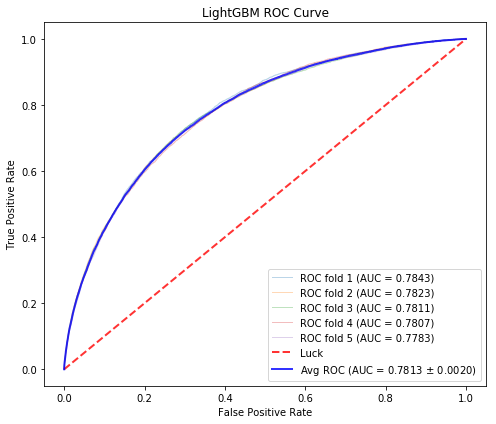

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot ROC curves
plt.figure(figsize=(7,6))
scores = [] 
for n_fold, (_, val_idx) in enumerate(folds.split(app_train)):  
    # Plot the roc curve
    fpr, tpr, thresholds = roc_curve(train_labels.iloc[val_idx], oof_preds[val_idx])
    score = roc_auc_score(train_labels.iloc[val_idx], oof_preds[val_idx])
    scores.append(score)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
fpr, tpr, thresholds = roc_curve(train_labels, oof_preds)
score = roc_auc_score(train_labels, oof_preds)
plt.plot(fpr, tpr, color='b',
         label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

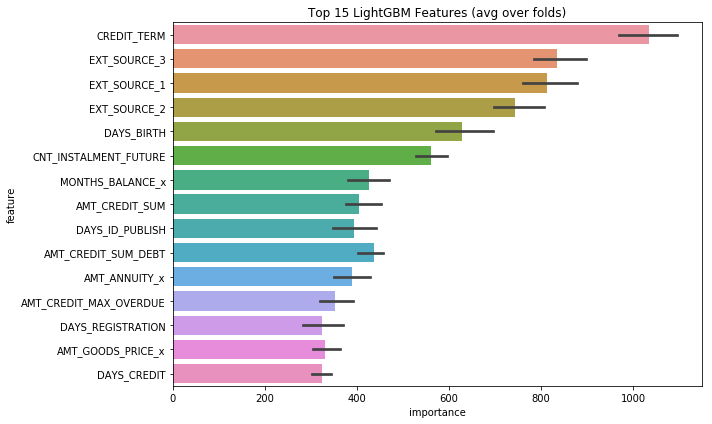

In [14]:
# Plot feature importances
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:15].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('Top 15 LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

